# Forecasting time series

## Using statistical models

This code is not intended to run in automatic mode, but rather invites to stop, see options and choose according to model trade-offs.

Please feel free to use other time series to forecast.

This specific example shows:

* It is more complex to forecast at it seems
* However, simple approaches may work better, it all depends on problem needs

More details at the end of this code, under Conclusions.

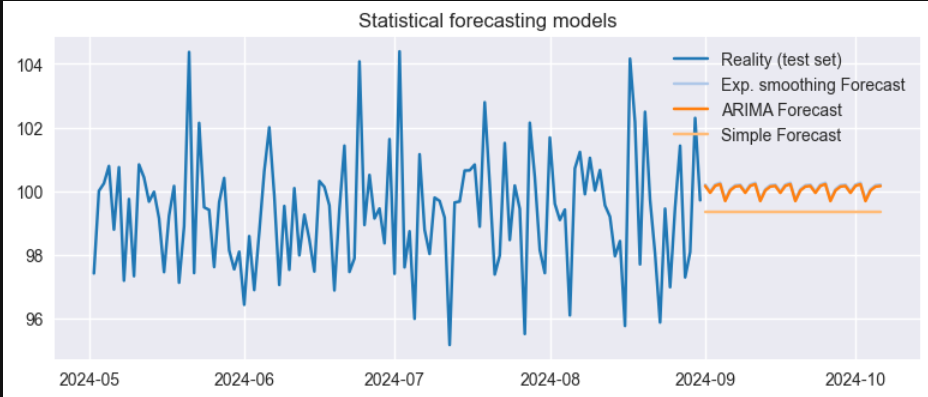

* Statistical models are useful to forecast time series without too much complexity
* Statistical models compared to machine learning models for forecasting:
    * Are faster to model
    * Are in general easier to understand (better explainability)
    * Are not able to model very complex time series 
* ARIMA models have a couple of advantages on exponential smoothing models:
    * Can use exogenous variables (holidays, weather, economic indexes...)
    * Are less prone to lose accuracy along future
    * Directly deliver confidence intervals

# Importing libraries

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Graphics (normal)
from cycler import cycler

plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('tab20').colors)  #tab20b

import plotly.express as px  # Graphics (more options and interactivity)

from statsmodels.tsa.seasonal import seasonal_decompose  # Divides time series in trend, seasonal and residues, to find seasonality
from statsmodels.tsa.stattools import adfuller, kpss     # time series stationary test
import statsmodels.api as sm                             # For Q-Q plot and others
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # To avoid messages such us 'deprecated in future versions'
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Auto correlation and partial autocorrelation functions

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import ndiffs                        # To estimate 'd' for ARIMA models

from sklearn.model_selection import train_test_split  # Divides time series. Remember": shuffle=False

# Generating random data

Values have a normal distribution of mean: 100 and standard deviation of 2.

Please feel free to run this code using any other time series.

In [120]:
# Create a date range from 2023-01-01 to 2024-08-31
dates = pd.date_range(start='2023-01-01', end='2024-08-31', freq='D')

# Generate normally distributed values with mean 100 and standard deviation 2
values = np.random.normal(loc=100, scale=2, size=len(dates))

# Create the DataFrame
df = pd.DataFrame({'Value': values}, index=dates)


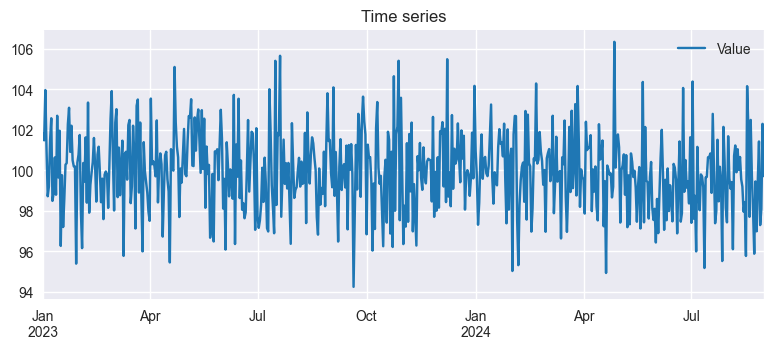

In [281]:
df.plot()
plt.title('Time series')
plt.show()

# Assessing trend, seasonal and residual components of time series

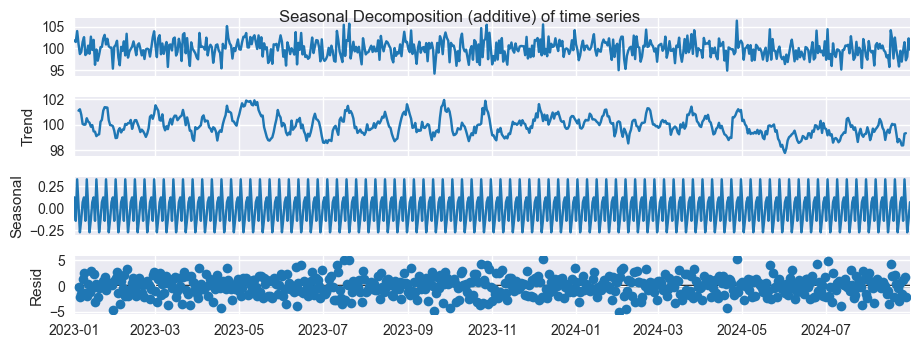

In [282]:
decomposition = seasonal_decompose(df, model='additive')  # or model='multiplicative'

# Plot the components
decomposition.plot()
plt.suptitle("Seasonal Decomposition (additive) of time series")
#plt.tight_layout()
plt.show()

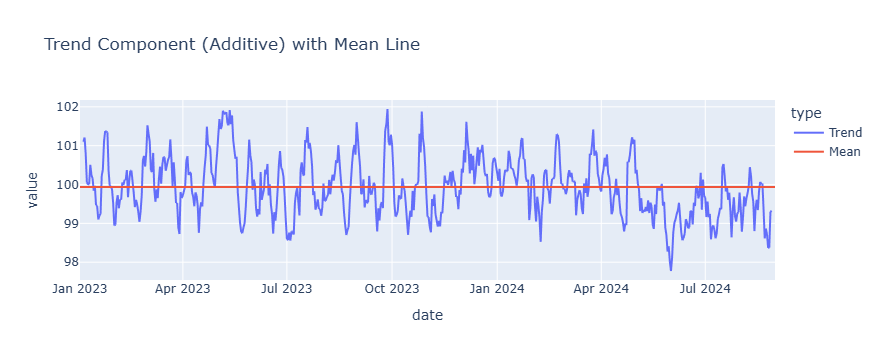

In [283]:
# Plot using plotly express

trend_series = decomposition.trend
mean_value = trend_series.mean()

combined_df = pd.DataFrame({
    'date': trend_series.index.tolist() * 2,
    'value': list(trend_series.values) + [mean_value] * len(trend_series),
    'type': ['Trend'] * len(trend_series) + ['Mean'] * len(trend_series)
})

# Plot both lines
figplotly = px.line(combined_df, x='date', y='value', color='type',
                    title='Trend Component (Additive) with Mean Line')
figplotly.show()



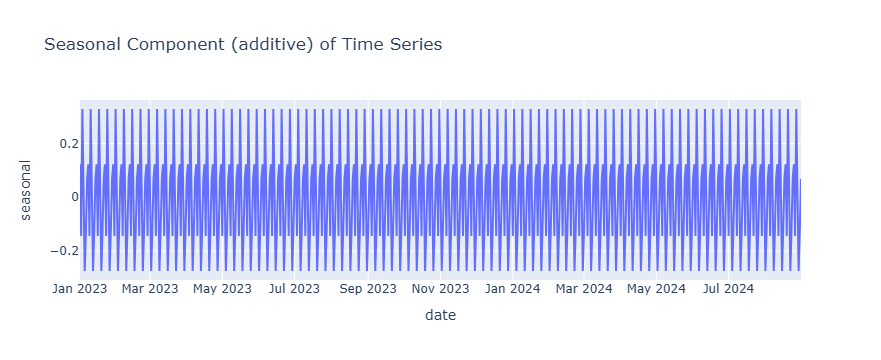

In [284]:
# Plot using Plotly Express
seasonal_df = pd.DataFrame({
    'date': decomposition.seasonal.index,
    'seasonal': decomposition.seasonal.values
})

figplotly = px.line(seasonal_df, x='date', y='seasonal', title='Seasonal Component (additive) of Time Series')
figplotly.show()


# Assessing whether time series is stationary

This is a requirement for the ARIMA statistica models

In [285]:
adfuller(df)

(-16.588570281378395,
 1.8074662198564543e-29,
 1,
 607,
 {'1%': -3.441169060335662,
  '5%': -2.866313284942438,
  '10%': -2.56931205548122},
 2471.550377660238)

In [286]:
test_result = 'not ' if adfuller(df)[1] > 0.05 else ''

print(f'The augmented Dickey-Fuller test did {test_result}confirm the stationary hypothesis')

The augmented Dickey-Fuller test did confirm the stationary hypothesis


In [287]:
kpss(df)

C:\Users\fc2\AppData\Local\Temp\ipykernel_14220\219064743.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(0.7904070890898142,
 0.01,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [288]:
test_result = 'not ' if kpss(df)[1] > 0.05 else ''

print(f'The Kwiatkowski-Phillips-Schmidt-Shin test did {test_result}reject the stationary hypothesis')

The Kwiatkowski-Phillips-Schmidt-Shin test did reject the stationary hypothesis


C:\Users\fc2\AppData\Local\Temp\ipykernel_14220\1635481337.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




# Splitting data into train and test data

This allows to model using train data and verify models using test data

In [289]:
X = df.drop(columns='Value')
y = df.Value

# Use shuffle=False to preserve chronological order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Forecast with Exponential Smoothing model

## Setting grid search for parameters of this statisticam model

In [290]:
trend_options = ['additive', 
                 #'multiplicative',
                 None
                ]
damped_trend_options = [#True, 
                        False
                       ]
seasonal_options = ['additive', 
                    #'multiplicative',
                     None
                   ]
seasonal_periods_options = [#3, 6, 
                            7, 
                            #12, 15
                           ]

## Run grid to find best model

The for loops could be coded in a more pythonic way.

It was left this way for better readability and lack of need to enlarge loop

In [291]:
results_dictionary = {}
results_dictionary_index = 0

for trend in trend_options:
    for damped_trend in damped_trend_options:
        for seasonal in seasonal_options:
            for seasonal_periods in seasonal_periods_options:
                # Initializing model
                exp = ExponentialSmoothing(
                    y_train,                              # Univariate time series (training split)
                    trend = trend,                        # Grid search
                    damped_trend= damped_trend,           # Grid search
                    seasonal= seasonal,                   # Grid search
                    seasonal_periods= seasonal_periods,   # Grid search
                    use_boxcox= True,                     # In general, a better model
                    freq= 'D'                            # Optional if date index shows evident option         
                )
                # Fitting model with convergence check
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("always")
                    model=exp.fit(use_brute=True, optimized=True, method='L-BFGS-B')
                    
                    # Check for convergence warning
                    did_not_converge = any(
                        issubclass(warning.category, ConvergenceWarning) for warning in w)


                # Prediction (forecast of y_test)
                y_predicted = model.forecast(steps=len(X_test))
                # y_predicted.index = X_test.index # Not required in this grid search phase

                if not did_not_converge:
                    # Align and drop NaNs
                    y_test_clean, y_pred_clean = np.array(y_test), np.array(y_predicted)
                    mask = ~np.isnan(y_test_clean) & ~np.isnan(y_pred_clean)
                    
                    if mask.sum() > 0:  # ✅ Only compute metrics if there's valid data
                        results_dictionary[results_dictionary_index] = {
                            'has_converged': not did_not_converge,
                            'trend': trend,
                            'damped_trend': damped_trend,
                            'seasonal': seasonal,
                            'seasonal_periods': seasonal_periods,
                            'bias': (y_test_clean[mask] - y_pred_clean[mask]).mean(),
                            'RMSE': (mean_squared_error(y_test_clean[mask], y_pred_clean[mask]) ** 0.5),
                            'MAE': mean_absolute_error(y_test_clean[mask], y_pred_clean[mask]),
                            'MAPE': mean_absolute_percentage_error(y_test_clean[mask], y_pred_clean[mask]),
                            'AIC': model.aic,
                            'AICc': model.aicc,
                            'BIC': model.bic
                            }
                else:
                    results_dictionary[results_dictionary_index] = {
                        'has_converged': not did_not_converge,
                        'trend': trend,
                        'damped_trend': damped_trend,
                        'seasonal': seasonal,
                        'seasonal_periods': seasonal_periods,
                        'bias': np.inf,
                        'RMSE': np.inf,
                        'MAE': np.inf,
                        'MAPE': np.inf,
                        'AIC': np.inf,
                        'AICc': np.inf,
                        'BIC': np.inf
                        }
                
                print(f'step converged: {not did_not_converge}, trend: {trend}, damped: {damped_trend}, seasonal: {seasonal}, periods: {seasonal_periods}')
                
                # Index for next loop
                results_dictionary_index = results_dictionary_index + 1
                
# Store results of model grid search in a dataframe
results_df = pd.DataFrame.from_dict(results_dictionary).T

display(results_df.sort_values(by='RMSE'))

step converged: True, trend: additive, damped: False, seasonal: additive, periods: 7
step converged: True, trend: additive, damped: False, seasonal: None, periods: 7
step converged: True, trend: None, damped: False, seasonal: additive, periods: 7
step converged: True, trend: None, damped: False, seasonal: None, periods: 7


,has_converged,trend,damped_trend,seasonal,seasonal_periods,bias,RMSE,MAE,MAPE,AIC,AICc,BIC
0,True,additive,False,additive,7,-0.725151,1.984648,1.553379,0.015727,675.77078,676.540336,721.841685
1,True,additive,False,None,7,-0.727098,1.987321,1.571119,0.015904,665.441026,665.616026,682.194083
2,True,None,False,additive,7,-0.759418,1.99839,1.566512,0.015863,671.789782,672.345571,709.484159
3,True,None,False,None,7,-0.762412,2.000325,1.583758,0.016036,661.474621,661.557609,669.85115


## Choice of best parameters for exponential smoothing model

Best model will depend on problem needs, I am picking here one model as example, not necessarily being the best for all problems

In [292]:
best_parameters = results_df.iloc[2,:]

## Creation of exponential smoothing model

In [293]:
exp = ExponentialSmoothing(
                    y_train,                              # Univariate time series (training split)
                    trend = best_parameters.trend,                        # Grid search results
                    damped_trend= best_parameters.damped_trend,           # Grid search results
                    seasonal= best_parameters.seasonal,                   # Grid search results
                    seasonal_periods= best_parameters.seasonal_periods,   # Grid search results
                    use_boxcox= True,                     # In general, a better model
                    freq= 'D'                            # Optional if date index shows evident option         
                )

model_exponential_smoothing=exp.fit(use_brute=True, optimized=True, method='L-BFGS-B')

Parameters of model

In [294]:
model_exponential_smoothing.params

{'smoothing_level': 1.4901161193847656e-08,
 'smoothing_trend': nan,
 'smoothing_seasonal': 0.0,
 'damping_trend': nan,
 'initial_level': 58.06506551276388,
 'initial_trend': nan,
 'initial_seasons': array([-0.00408124, -0.11242039, -0.00217645,  0.02462382, -0.24111774,
        -0.07502005, -0.01336906]),
 'use_boxcox': True,
 'lamda': 0.8508344902000223,
 'remove_bias': False}

## Visual results

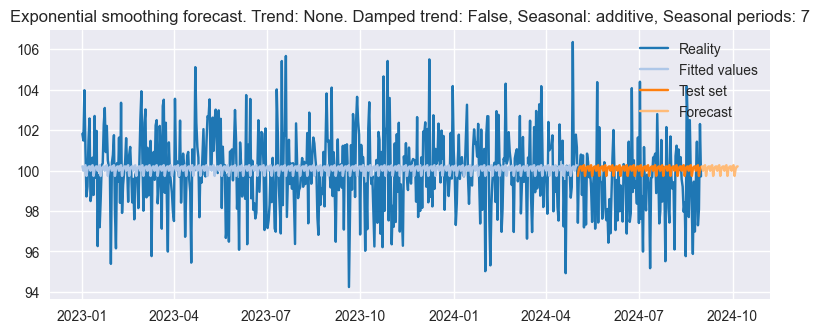

In [295]:
plt.plot(y, label = 'Reality')
plt.plot(model_exponential_smoothing.fittedvalues, label='Fitted values')
plt.plot(model_exponential_smoothing.forecast(steps=len(X_test)), label='Test set')
plt.plot(model_exponential_smoothing.forecast(steps=len(X_test) + 36).tail(36), label='Forecast')
plt.title(f'Exponential smoothing forecast. Trend: {best_parameters.trend}. Damped trend: {best_parameters.damped_trend}, Seasonal: {best_parameters.seasonal}, Seasonal periods: {best_parameters.seasonal_periods}')
plt.legend(loc='best')
plt.show()

## Analysis of residuals

Residuals must comply certain requirements to validate this statisticam model

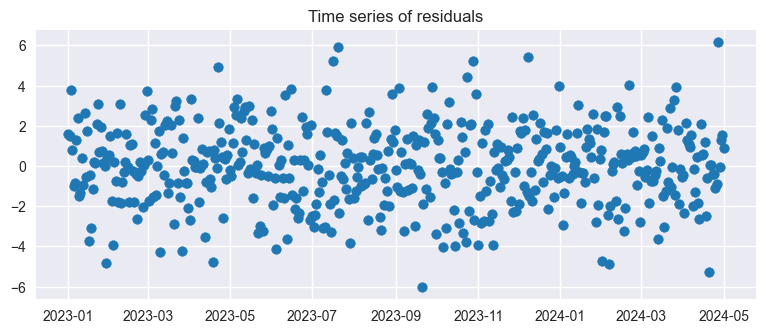

In [296]:
plt.scatter(model_exponential_smoothing.resid.index, model_exponential_smoothing.resid, 
         #linestyle='-.',
         marker='o'
        )
plt.title('Time series of residuals')
plt.show()

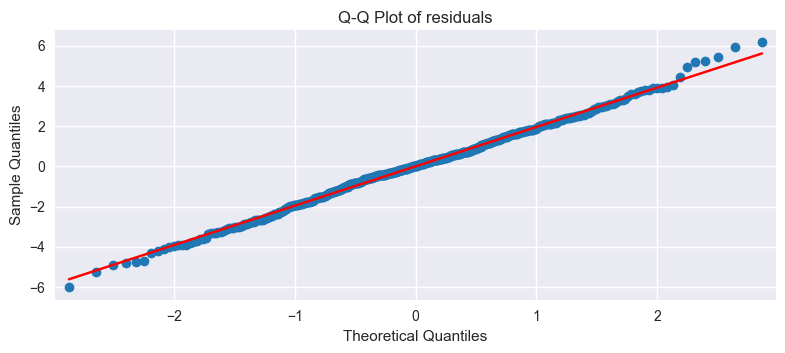

In [297]:
fig = sm.qqplot(model_exponential_smoothing.resid, line='s')
plt.title("Q-Q Plot of residuals")
plt.show()

# Forecast with ARIMA model

## Verifying need for differentiation 

A way to make time series stationary, a requirement for ARIMA models

In [298]:
for test in ['kpss', 'adf', 'pp']:
    print(f'Suggested # for differentiation (test: {test}): {ndiffs(df, test=test)}')

Suggested # for differentiation (test: kpss): 1
Suggested # for differentiation (test: adf): 0
Suggested # for differentiation (test: pp): 0


In [299]:
test_result = 'not ' if adfuller(df)[1] > 0.05 else ''

print(f'The augmented Dickey-Fuller test did {test_result}confirm the stationary hypothesis')

The augmented Dickey-Fuller test did confirm the stationary hypothesis


### For cases where stationary hypothesis is rejected

The degrees of differentiation should be iteratively estimated.

One statistical method is: 

adfuller(y.diff(periods= xxxx ).dropna()), where xxxx is the differentation level 
(test first 1, then 2 if needed and so forth)

One alternative is also to modify time series data using any transformation, like boxcox.

## Estimating parameters for ARIMA model

To make this notebook short, please for model details, search in literature or internet

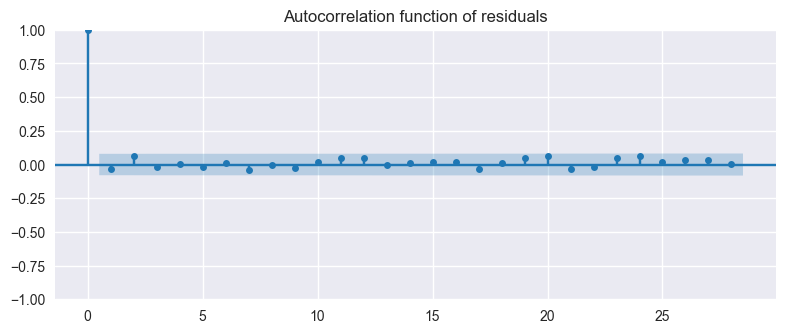

In [300]:
fig = plot_acf(df)
plt.title("Autocorrelation function of residuals")
plt.show()

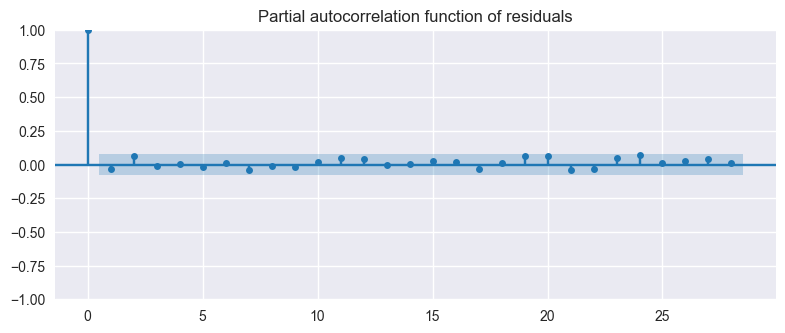

In [301]:
fig = plot_pacf(df)
plt.title("Partial autocorrelation function of residuals")
plt.show()

## Setting grid search for parameters of this statistical model

In [313]:
p_options = [0, 1]       # hint from partial autocorrelation function chart
d_options = [0]          # Already indentified
q_options = [0, 1]       # hint from autocorrelation function chart

P_options = [0, 1]     # hint from partial autocorrelation function chart
D_options = [0, 1]
Q_options = [0, 1]     # hint from autocorrelation function chart
s_options = [7]        # Already identified

trend_options = [None, 'c']    # hint from trend decomposition chart

frequency = 'D'        # Check it, please, it can vary according to problem and data

## Run grid to find best model

The for loops could be coded in a more pythonic way.

It was left this way for better readability and lack of need to enlarge loop

In [303]:
results_dictionary = {}
results_dictionary_index = 0

for p in p_options:
    for d in d_options:
        for q in q_options:
            for P in P_options:
                for D in D_options:
                    for Q in Q_options:
                        for s in s_options:
                            for trend in trend_options:

                                with warnings.catch_warnings(record=True) as w:
                                    warnings.simplefilter("always")

                                    # Initialize and fit model
                                    arima = SARIMAX(
                                        y_train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        trend=trend,
                                        freq=frequency
                                    )
                                    try:
                                        model_arima = arima.fit(maxiter=200, disp=True)
                                    except np.linalg.LinAlgError:
                                        print(f"LinAlgError at p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}, trend={trend}")
                                        continue

                                    # Check for convergence warning
                                    did_not_converge = any(
                                        issubclass(warning.category, ConvergenceWarning) for warning in w
                                    )

                                # Get forecasted values
                                forecast = model_arima.get_forecast(steps=len(X_test))
                                y_predicted = forecast.predicted_mean

                                # Align and clean
                                y_test_clean = y_test.copy()
                                y_pred_clean = y_predicted.copy()
                                mask = ~y_test_clean.isna() & ~y_pred_clean.isna()

                                if mask.sum() > 0:
                                    bias = (y_test_clean[mask] - y_pred_clean[mask]).mean()
                                    rmse = mean_squared_error(y_test_clean[mask], y_pred_clean[mask]) ** 0.5
                                    mae = mean_absolute_error(y_test_clean[mask], y_pred_clean[mask])
                                    mape = mean_absolute_percentage_error(y_test_clean[mask], y_pred_clean[mask])
                                else:
                                    bias = rmse = mae = mape = np.inf

                                # Store results
                                results_dictionary[results_dictionary_index] = {
                                    'p': p,
                                    'd': d,
                                    'q': q,
                                    'P': P,
                                    'D': D,
                                    'Q': Q,
                                    's': s,
                                    'trend': trend,
                                    'bias': bias,
                                    'RMSE': rmse,
                                    'MAE': mae,
                                    'MAPE': mape
                                }

                                results_dictionary_index += 1

# Convert to DataFrame
results_df = pd.DataFrame.from_dict(results_dictionary, orient='index')
display(results_df.sort_values(by='RMSE'))

,p,d,q,P,D,Q,s,trend,bias,RMSE,MAE,MAPE
55,1,0,1,0,1,1,7,c,-0.724673,1.984326,1.553478,0.015727
63,1,0,1,1,1,1,7,c,-0.718705,1.984839,1.557475,0.015767
47,1,0,0,1,1,1,7,c,-0.718501,1.985175,1.557710,0.015769
31,0,0,1,1,1,1,7,c,-0.718476,1.985177,1.557695,0.015769
15,0,0,0,1,1,1,7,c,-0.718999,1.985498,1.557899,0.015771
...,...,...,...,...,...,...,...,...,...,...,...,...
18,0,0,1,0,0,1,7,None,96.147986,96.984582,96.147986,0.967905
2,0,0,0,0,0,1,7,None,96.474844,97.198419,96.474844,0.971222
16,0,0,1,0,0,0,7,None,98.809479,99.004545,98.809479,0.994626
0,0,0,0,0,0,0,7,None,99.332994,99.350208,99.332994,1.000000


## Choice of best parameters for ARIMA model

In [304]:
results_df.loc[( (results_df.iloc[:,0:6].sum(axis=1)<4) & (results_df.RMSE < 2) )].sort_values(by='bias', ascending=False)

,p,d,q,P,D,Q,s,trend,bias,RMSE,MAE,MAPE
15,0,0,0,1,1,1,7,c,-0.718999,1.985498,1.557899,0.015771
39,1,0,0,0,1,1,7,c,-0.725053,1.985651,1.554256,0.015735
23,0,0,1,0,1,1,7,c,-0.725190,1.985711,1.554306,0.015736
7,0,0,0,0,1,1,7,c,-0.725299,1.985907,1.554472,0.015738
14,0,0,0,1,1,1,7,None,-0.756452,1.999180,1.570963,0.015908
38,1,0,0,0,1,1,7,None,-0.761914,1.999210,1.567269,0.015871
22,0,0,1,0,1,1,7,None,-0.761934,1.999234,1.567283,0.015872
6,0,0,0,0,1,1,7,None,-0.762264,1.999515,1.567534,0.015874


In [305]:
best_parameters = results_df.iloc[7,:]

## Creation of ARIMA model

In [306]:
arima = SARIMAX(y_train,
                order=(best_parameters.p, best_parameters.d, best_parameters.q),
                seasonal_order=(best_parameters.P, best_parameters.D, best_parameters.Q, best_parameters.s),
                trend= best_parameters.trend,
                freq= frequency
               )

model_arima = arima.fit(maxiter=200, disp=True)

In [337]:
forecast_arima = model_arima.get_forecast(steps=len(X_test)+36)

y_predicted_arima = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

## Visual results

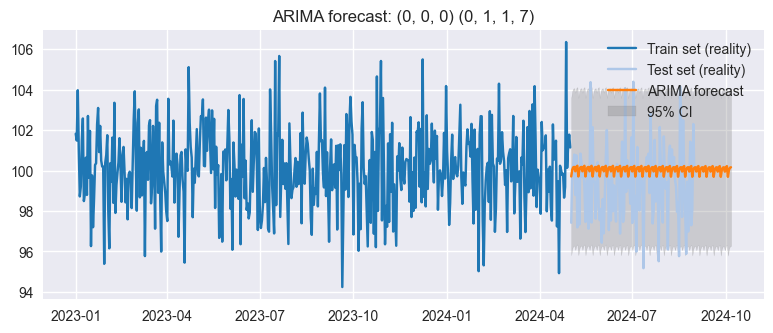

In [331]:
plt.plot(y_train, label='Train set (reality)')
plt.plot(y_test, label = 'Test set (reality)')
plt.plot(y_predicted_arima.index, y_predicted_arima, label='ARIMA forecast')
plt.fill_between(y_predicted_arima.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')
plt.title(f'ARIMA forecast: ({best_parameters.p}, {best_parameters.d}, {best_parameters.q}) ({best_parameters.P}, {best_parameters.D}, {best_parameters.Q}, {best_parameters.s})')
plt.legend(loc='best')
plt.show()

## Analysis of residuals

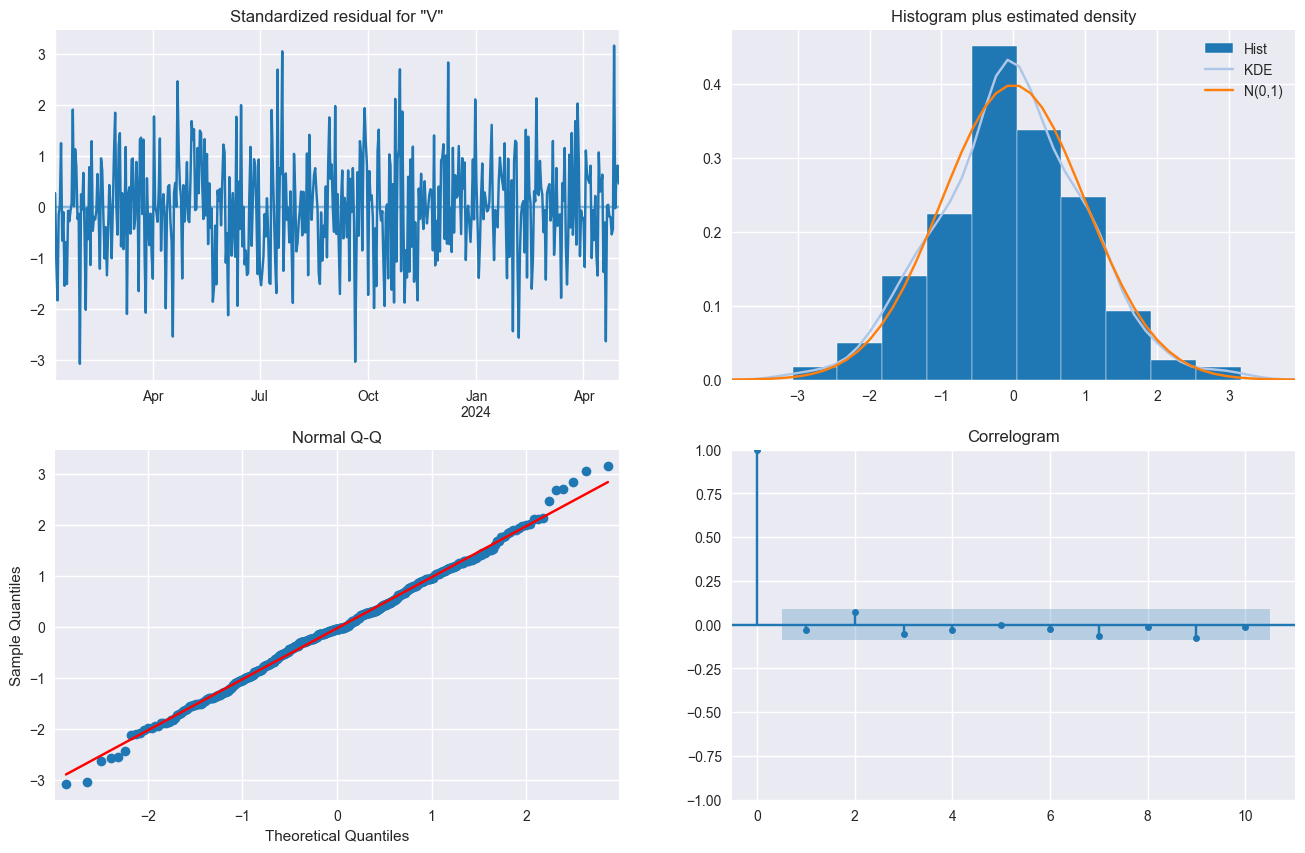

In [333]:
model_arima.plot_diagnostics(figsize=(16,10))
plt.show()

# Comparing both statistical models for forecasting

## Visual comparison

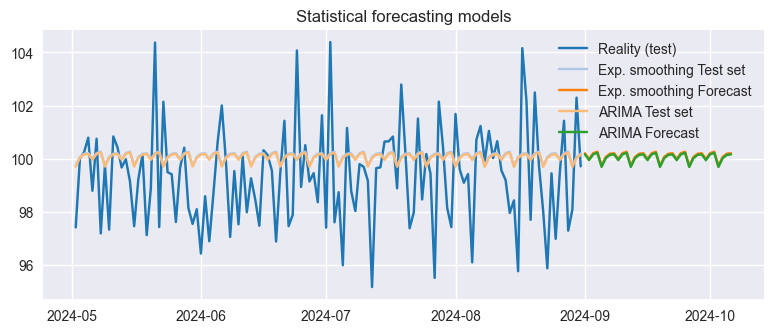

In [334]:
plt.plot(y_test, label = 'Reality (test)')
plt.plot(model_exponential_smoothing.forecast(steps=len(X_test)), label='Exp. smoothing Test set')
plt.plot(model_exponential_smoothing.forecast(steps=len(X_test) + 36).tail(36), label='Exp. smoothing Forecast')
plt.plot(y_predicted_arima.head(-36), label='ARIMA Test set')
plt.plot(y_predicted_arima.tail(36), label='ARIMA Forecast')

plt.title(f'Statistical forecasting models')
plt.legend(loc='best')
plt.show()

## Comparison of metrics

In [335]:
y_predicted_exponential_metrics = model_exponential_smoothing.forecast(steps=len(X_test))
y_predicted_arima_metrics = y_predicted_arima.head(-36)

metric = ['bias', 'RMSE', 'MAE', 'MAPE']

values_dict = {
            'exp_smoothing': [(y_test - y_predicted_exponential_metrics).mean(),
                               mean_squared_error(y_test, y_predicted_exponential_metrics) ** 0.5,
                               mean_absolute_error(y_test, y_predicted_exponential_metrics),
                               mean_absolute_percentage_error(y_test, y_predicted_exponential_metrics)
                               ],
            'ARIMA': [(y_test - y_predicted_arima).mean(),
                               mean_squared_error(y_test, y_predicted_arima_metrics) ** 0.5,
                               mean_absolute_error(y_test, y_predicted_arima_metrics),
                               mean_absolute_percentage_error(y_test, y_predicted_arima_metrics)
                               ]
}

metric_df = pd.DataFrame(values_dict, index=metric)

display(metric_df)

,exp_smoothing,ARIMA
bias,-0.759418,-0.725299
RMSE,1.998390,1.985907
MAE,1.566512,1.554472
MAPE,0.015863,0.015738


## Comparison of metrics with a very simple model

In [336]:
y_constant = [y_test.mean()] * len(y_test)
print((y_test - y_constant).mean(),
                               mean_squared_error(y_test, y_constant) ** 0.5,
                               mean_absolute_error(y_test, y_constant),
                               mean_absolute_percentage_error(y_test, y_constant))

-9.318593255870167e-16 1.8493321458052003 1.445325582785052 0.014535433800907134


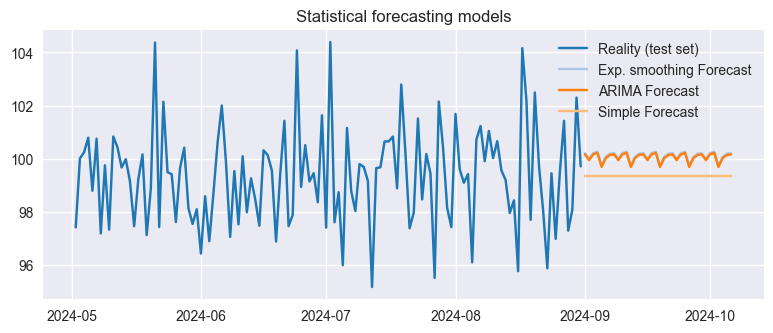

In [345]:
plt.plot(y_test, label = 'Reality (test set)')
#plt.plot(model_exponential_smoothing.forecast(steps=len(X_test)), label='Exp. smoothing Test set')
plt.plot(model_exponential_smoothing.forecast(steps=len(X_test) + 36).tail(36), label='Exp. smoothing Forecast')
#plt.plot(y_predicted_arima.head(-36), label='ARIMA Test set')
plt.plot(y_predicted_arima.tail(36), label='ARIMA Forecast')
plt.plot(y_predicted_arima.tail(36).index, [y_test.mean()] * len(y_predicted_arima.tail(36).index), label='Simple Forecast')

plt.title(f'Statistical forecasting models')
plt.legend(loc='best')
plt.show()

# Conclusions

* Statistical models are useful to forecast time series without too much complexity
* Statistical models compared to machine learning models for forecasting:
    * Are faster to model
    * Are in general easier to understand (better explainability)
    * Are not able to model very complex time series 
* ARIMA models have a couple of advantages on exponential smoothing models:
    * Can use exogenous variables (holidays, weather, economic indexes...)
    * Are less prone to lose accuracy along future
    * Directly deliver confidence intervals

In any case, this particular example shows that analysing data before starting complex work can give a hint about a very simple model which, in this case and for this problem needs, outperforms both more complex models.